In [33]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#sklearn - Machine Learning Package
import sklearn.model_selection as modsel
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence


### Load and Inspect Data

In [4]:
filename = 'diabetes.csv'
DT = pd.read_csv(filename,sep=',')

####
# Data Inspection
# - Total Number of Records and Features
# - Unique Feature Data Types
# - Presence of Null Entries
####

print('Dimensions: %s records x %s features.' % DT.shape)

print('Unique Feature Data Types: %s' % len(DT.dtypes.unique()))
for x in DT.dtypes.unique():
    print(' -> '+str(x))

null_idx = DT.isnull().any().values
null_idx = null_idx[null_idx==True]
print('')
print('NULL Entries: %s \n' % len(null_idx))
if(len(null_idx)>0):
    for x in null_idx:
        if(DT.iloc[:,x].isnull()):
            print(' - ' + str(x) + ' has %s NULL entries' % len(DT[x].isnull()))
del null_idx

print(DT.info())

Dimensions: 768 records x 9 features.
Unique Feature Data Types: 2
 -> int64
 -> float64

NULL Entries: 0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


### Split Data into Training and Test Sets

In [5]:
#Proportion of Data Used for Test Set
prop_test = 0.2

cols = DT.columns[0:-1]
str_output = 'Outcome'

#Create Train & Test Sets
X_train, X_test, y_train, y_test = modsel.train_test_split(
                DT[cols],
                DT[str_output],
                test_size=prop_test, 
                random_state=1234)

### Model Tuning Parameters

In [14]:
#{‘deviance’, ‘exponential’}
loss = 'deviance'

#{'friedman_mse','mse','mae'}
criterion = 'friedman_mse'

# int: consider all features
# float: consider a percentage of features
# {'sqrt','log2','auto'}
# None
max_features = 'sqrt'

# if subsample < 1.0, results in stochastic gradient boosting
subsample = 0.8

# True, False, 'auto'
presort = 'auto'

learning_rate = 0.1
n_estimators = 100
max_depth = 3
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
min_impurity_split = 1e-7
verbose = 0
warm_start = False
random_state = 123456

init = None
max_leaf_nodes = None 

### Initialize & Train Model Object

In [15]:
model_gtb_class=GradientBoostingClassifier(loss=loss, 
                           learning_rate=learning_rate,
                           n_estimators=n_estimators, 
                           subsample=subsample, 
                           criterion=criterion,
                           min_samples_split=min_samples_split, 
                           min_samples_leaf=min_samples_leaf, 
                           min_weight_fraction_leaf=min_weight_fraction_leaf, 
                           max_depth=max_depth, 
                           min_impurity_split=min_impurity_split, 
                           init=init,
                           random_state=random_state, 
                           max_features=max_features, 
                           verbose=verbose, 
                           max_leaf_nodes=max_leaf_nodes, 
                           warm_start=warm_start, 
                           presort=presort)

#Train Model on Data
model_gtb_class.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0,
              n_estimators=100, presort='auto', random_state=123456,
              subsample=0.8, verbose=0, warm_start=False)

### Model Validation - Training Set

In [16]:
train_preds = model_gtb_class.predict(X_train)
print(classification_report(y_train,train_preds))

             precision    recall  f1-score   support

          0       0.90      0.96      0.93       401
          1       0.91      0.79      0.85       213

avg / total       0.90      0.90      0.90       614



### Model Validation - Test Set

In [17]:
test_preds = model_gtb_class.predict(X_test)
print(classification_report(y_test,test_preds))

             precision    recall  f1-score   support

          0       0.78      0.88      0.83        99
          1       0.72      0.56      0.63        55

avg / total       0.76      0.77      0.76       154



### Model Validation - ROC Curve

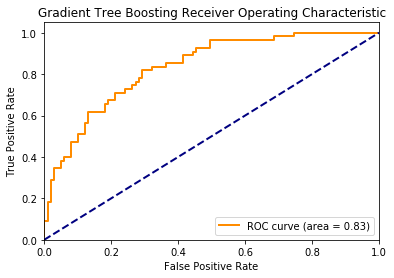

In [18]:
#Calculate Probabilities for Class 1
test_probs = model_gtb_class.predict_proba(X_test)

#Calculate FPR and TPR for Difference Thresholds
fpr, tpr,thresholds = metrics.roc_curve(y_true=y_test,y_score = test_probs[:,1])

#Calculate AUC for ROC
auc = metrics.roc_auc_score(y_true=y_test,y_score = test_probs[:,1])

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Tree Boosting Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Feature Importance - Splitting Based

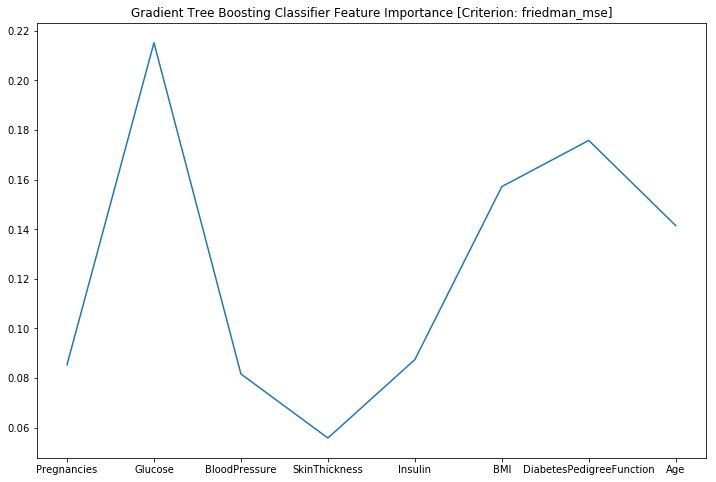

In [54]:
plt.figure(figsize=(12,8))
plt.plot(model_gtb_class.feature_importances_)
plt.xticks(range(X_test.shape[1]), X_test.columns)
plt.title('Gradient Tree Boosting Classifier Feature Importance [Criterion: ' + criterion+']')
plt.show()

### Feature Importance - Partial Dependence

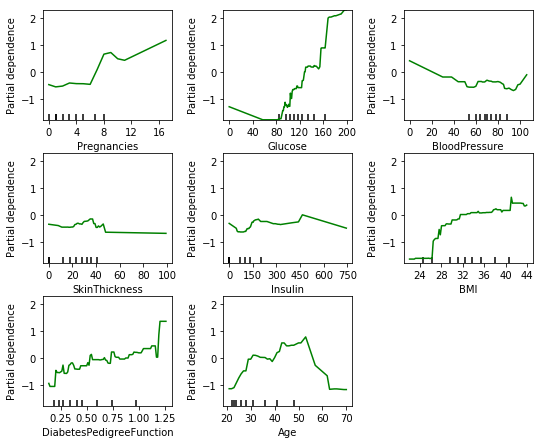

In [53]:
features = [0,1,2,3,4,5,6,7,]
fig, axs = plot_partial_dependence(model_gtb_class,
                                   X_test,
                                   features = features,
                                   feature_names = X_test.columns,
                                   figsize=(8,10)) 